In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from data_split import data_split_generator
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt

In [2]:
[x for x in product(range(10), range(3))]

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2),
 (5, 0),
 (5, 1),
 (5, 2),
 (6, 0),
 (6, 1),
 (6, 2),
 (7, 0),
 (7, 1),
 (7, 2),
 (8, 0),
 (8, 1),
 (8, 2),
 (9, 0),
 (9, 1),
 (9, 2)]

In [70]:
def make_x_y(data: pd.DataFrame):
    data = data.copy(deep=True)
    data.reset_index(drop=True, inplace=True)
    # data['']
    data.drop(columns=['dates', 'target_dates'], inplace=True)
    # month = month_encoder.transform(data[['month']]).toarray()
    # month = pd.DataFrame(month, columns=[str(x) for x in month_encoder.categories_[0].tolist()])
    # data:pd.DataFrame = pd.concat([data, month], axis = 1)
    Y = data.pop('target_sunspots')
    return data , Y
def get_metric(y_true, y_predict):
    RMSE = np.sqrt(mean_squared_error(y_true, y_predict))
    bias = sum(y_predict - y_true) / sum(y_true)
    # MAE = mean_absolute_error(y_true, y_predict)
    # MAPE = mean_absolute_percentage_error(y_true, y_predict)
    return RMSE, bias

# train_x, train_y, month_encoder = make_x_y(train_data)
# train_x

In [71]:
final_metric = []
for j in tqdm(range(120, 133)):
    data = pd.read_csv(f'./data/pca_data_{j}.csv')
    data['target_dates'] = pd.to_datetime(data['target_dates'])
    n_estimators = range(40, 51, 5)
    max_depth = range(40, 51, 5)
    criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
    for n_estimators, max_depth, criterion in product(n_estimators, max_depth, criterion):
        metrics = []
        data_split = data_split_generator(data)
        for train_data, vali_data in data_split:
            train_x, train_y = make_x_y(train_data)
            rf = RandomForestRegressor(n_jobs=6, n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
            rf.fit(X=train_x, y=train_y)
            vali_x, vali_y = make_x_y(vali_data)
            predict = rf.predict(vali_x)
            metric = get_metric(vali_y, predict)

            metrics.append(metric)
        metrics = pd.DataFrame(metrics, columns=['rmse', 'bias'])
        metrics['m'] = j
        metrics['n_estimators'] = n_estimators
        metrics['max_depth'] = max_depth
        metrics['criterion'] = criterion
        # print(metrics)
        final_metric.append(metrics)

final_metric = pd.concat(final_metric)
final_metric

100%|██████████| 13/13 [02:04<00:00,  9.61s/it]


rmse      bias    m  n_estimators  max_depth      criterion
0   67.487199  0.619039  120            40         40  squared_error
1   38.080714 -0.125079  120            40         40  squared_error
2   41.870068 -0.189727  120            40         40  squared_error
3   30.840077 -0.335212  120            40         40  squared_error
4   27.466339 -0.088672  120            40         40  squared_error
..        ...       ...  ...           ...        ...            ...
0   48.983892  0.354675  132            50         50        poisson
1   48.648927 -0.254379  132            50         50        poisson
2   39.980184 -0.303168  132            50         50        poisson
3   40.164992 -0.526303  132            50         50        poisson
4   29.478775 -0.039597  132            50         50        poisson

[2340 rows x 6 columns]

In [76]:
final_metric = final_metric.groupby(['n_estimators', 'max_depth', 'criterion', 'm']).mean().reset_index()
final_metric

n_estimators  max_depth       criterion    m       rmse      bias  rank
0              40         40  absolute_error  120  40.571893 -0.024541  84.6
1              40         40  absolute_error  121  40.531678 -0.052427  77.2
2              40         40  absolute_error  122  40.453860 -0.063937  91.8
3              40         40  absolute_error  123  43.497894 -0.069325  98.2
4              40         40  absolute_error  124  41.558916 -0.074530  83.2
..            ...        ...             ...  ...        ...       ...   ...
463            50         50   squared_error  128  39.928271 -0.120956  95.2
464            50         50   squared_error  129  39.388794 -0.124924  85.0
465            50         50   squared_error  130  40.107716 -0.108148  83.8
466            50         50   squared_error  131  40.699362 -0.109391  73.2
467            50         50   squared_error  132  40.946548 -0.139415  83.2

[468 rows x 7 columns]

In [77]:
final_metric["rank"] = final_metric.groupby(['m'])['rmse'].rank(method="dense", ascending=True)
grid_search_result = final_metric[final_metric['rank'] == 1.0]
grid_search_result.to_csv('./data/rf_grid_search_results.csv', index=False)
grid_search_result

n_estimators  max_depth       criterion    m       rmse      bias  rank
19             40         40    friedman_mse  126  39.579371 -0.068330   1.0
53             40         45  absolute_error  121  40.425555 -0.052300   1.0
104            40         50  absolute_error  120  40.088259 -0.032312   1.0
112            40         50  absolute_error  128  39.088516 -0.121710   1.0
119            40         50    friedman_mse  122  39.357905 -0.048600   1.0
121            40         50    friedman_mse  124  41.023267 -0.064163   1.0
181            45         40    friedman_mse  132  40.713520 -0.133921   1.0
226            45         45    friedman_mse  125  40.564193 -0.055830   1.0
230            45         45    friedman_mse  129  39.127695 -0.119665   1.0
354            50         40   squared_error  123  42.225180 -0.067267   1.0
361            50         40   squared_error  130  39.534971 -0.114614   1.0
371            50         45  absolute_error  127  38.986131 -0.115640   1.0
466            50         50   squared_error  131  40.699362 -0.109391   1.0

In [13]:
hypter_params = grid_search_result[grid_search_result.m == 120]
m, n_estimators, max_depth, criterion, metrics, rank = hypter_params.values[0]
m, n_estimators, max_depth, criterion, metrics, rank

(120, 45, 40, 'absolute_error', 40.10117787653484, 1.0)

In [14]:
def split_data(data):
    train_end_date = pd.to_datetime('1963-12-31')
    vali_end_date = pd.to_datetime('1973-12-31')
    test_end_date = pd.to_datetime('1983-12-31')
    train_start_date = train_end_date + pd.DateOffset(years=-30) + pd.offsets.MonthEnd(0)
    train_data = data[(data.target_dates >= train_start_date) & (data.target_dates <= train_end_date)]
    vali_data = data[(data.target_dates > train_end_date) & (data.target_dates <= vali_end_date)]
    test_data = data[(data.target_dates > vali_end_date) & (data.target_dates <= test_end_date)]
    return train_data, vali_data, test_data
train_data, vali_data, test_data = split_data(data)
train_data

x1          x2         x3       dates target_dates  \
2051 -132.264591  -71.152028  -8.550642  1922-12-31   1933-12-31   
2052 -134.426993  -74.662940   1.301216  1923-01-31   1934-01-31   
2053 -135.435246  -75.441004   5.179604  1923-02-28   1934-02-28   
2054 -131.083245  -78.307501  21.027288  1923-03-31   1934-03-31   
2055 -145.642574  -70.603453 -19.849659  1923-04-30   1934-04-30   
...          ...         ...        ...         ...          ...   
2407  -12.353115 -107.334913  68.876294  1952-08-31   1963-08-31   
2408  -12.174711 -107.632454  69.363180  1952-09-30   1963-09-30   
2409  -22.364940 -106.847142  61.820041  1952-10-31   1963-10-31   
2410  -29.216788 -109.061341  69.238278  1952-11-30   1963-11-30   
2411  -30.559882 -104.840841  50.046555  1952-12-31   1963-12-31   

      target_sunspots  
2051              0.3  
2052              3.4  
2053              7.8  
2054              4.3  
2055             11.3  
...               ...  
2407             33.2  
2408             38.8  
2409             35.3  
2410             23.4  
2411             14.9  

[361 rows x 6 columns]

In [18]:
results = []
for j in tqdm(range(120, 133)):
    data = pd.read_csv(f'./data/pca_data_{j}.csv')
    data['target_dates'] = pd.to_datetime(data['target_dates'])
    hypter_params = grid_search_result[grid_search_result.m == j]
    m, n_estimators, max_depth, criterion, metrics, rank = hypter_params.values[0]
    metrics = []
    data_split = data_split_generator(data)
    train_data, vali_data = next(data_split)
    train_data, vali_data, test_data = split_data(data)
    rf = RandomForestRegressor(n_jobs=6, n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
    train_x, train_y = make_x_y(train_data)
    rf.fit(X=train_x, y=train_y)
    predict = rf.predict(train_x)
    train_data['predict'] = predict
    train_data = train_data[['dates', 'target_dates', 'target_sunspots', 'predict']].copy(deep=True)
    train_data['type'] = 'train'
    train_data['m'] = j
    results.append(train_data)
    vali_x, vali_y = make_x_y(vali_data)
    predict = rf.predict(vali_x)
    vali_data['predict'] = predict
    vali_data = vali_data[['dates', 'target_dates', 'target_sunspots', 'predict']].copy(deep=True)
    vali_data['type'] = 'vali'
    vali_data['m'] = j
    results.append(vali_data)
    test_x, test_y = make_x_y(test_data)
    predict = rf.predict(test_x)
    test_data['predict'] = predict
    test_data = test_data[['dates', 'target_dates', 'target_sunspots', 'predict']].copy(deep=True)
    test_data['type'] = 'test'
    test_data['m'] = j
    results.append(test_data)

    data = pd.read_csv(f'./data/last_10_year_pca_data_{j}.csv')
    data['target_dates'] = pd.to_datetime(data['target_dates'])
    last_x, _ = make_x_y(data)
    predict = rf.predict(last_x)
    data['predict'] = predict
    data = data[['dates', 'target_dates', 'target_sunspots', 'predict']].copy(deep=True)
    data['type'] = 'prediction'
    data['m'] = j
    results.append(data)

results = pd.concat(results)
results

  0%|          | 0/13 [00:00<?, ?it/s]/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_25378/3267009428.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predict'] = predict
/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_25378/3267009428.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali_data['predict'] = predict
/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_25378/3267009428.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

dates target_dates  target_sunspots    predict        type    m
2063  1923-12-31   1933-12-31              0.3   3.517778       train  120
2064  1924-01-31   1934-01-31              3.4   5.151111       train  120
2065  1924-02-29   1934-02-28              7.8   7.017778       train  120
2066  1924-03-31   1934-03-31              4.3   6.840000       train  120
2067  1924-04-30   1934-04-30             11.3   9.202222       train  120
...          ...          ...              ...        ...         ...  ...
127   1983-08-31   1994-08-31              NaN  41.142222  prediction  132
128   1983-09-30   1994-09-30              NaN  43.973333  prediction  132
129   1983-10-31   1994-10-31              NaN  43.482222  prediction  132
130   1983-11-30   1994-11-30              NaN  45.286667  prediction  132
131   1983-12-31   1994-12-31              NaN  45.337778  prediction  132

[9451 rows x 6 columns]

In [26]:
results['lat'] = '45'
results['lon'] = '45'
results['year'] = results['target_dates'].dt.year
results

dates target_dates  target_sunspots    predict        type    m  \
2063  1923-12-31   1933-12-31              0.3   3.517778       train  120   
2064  1924-01-31   1934-01-31              3.4   5.151111       train  120   
2065  1924-02-29   1934-02-28              7.8   7.017778       train  120   
2066  1924-03-31   1934-03-31              4.3   6.840000       train  120   
2067  1924-04-30   1934-04-30             11.3   9.202222       train  120   
...          ...          ...              ...        ...         ...  ...   
127   1983-08-31   1994-08-31              NaN  41.142222  prediction  132   
128   1983-09-30   1994-09-30              NaN  43.973333  prediction  132   
129   1983-10-31   1994-10-31              NaN  43.482222  prediction  132   
130   1983-11-30   1994-11-30              NaN  45.286667  prediction  132   
131   1983-12-31   1994-12-31              NaN  45.337778  prediction  132   

     lat lon  year  
2063  45  45  1933  
2064  45  45  1934  
2065  45  45  1934  
2066  45  45  1934  
2067  45  45  1934  
...   ..  ..   ...  
127   45  45  1994  
128   45  45  1994  
129   45  45  1994  
130   45  45  1994  
131   45  45  1994  

[9451 rows x 9 columns]

In [47]:
results.groupby(['m', 'year', 'type']).mean()

/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_25378/2080267451.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



target_sunspots     predict
m   year type                                   
120 1933 train              0.300000    3.517778
    1934 train              8.716667   10.863519
    1935 train             36.058333   36.880648
    1936 train             79.733333   81.960926
    1937 train            114.400000  113.528704
...                              ...         ...
132 1990 prediction              NaN  170.030185
    1991 prediction              NaN  147.762407
    1992 prediction              NaN   78.132778
    1993 prediction              NaN   59.139444
    1994 prediction              NaN   44.560185

[805 rows x 2 columns]

In [37]:
target_sunspots_1940 = results[results.year == 1940].groupby(['year', 'lat', 'lon']).agg({'target_sunspots':'mean'}).reset_index()
target_sunspots_1940

year lat lon  target_sunspots
0  1940  45  45        67.783333

In [38]:
import plotly.express as px
#在地图上绘制密度图

fig = px.density_mapbox(target_sunspots_1940
                        , lat='lat'       #设置纬度
                        ,lon='lon'        #设置经度
                        , z='target_sunspots'                 #设置密度
                        , radius=60,
                        center=dict(lat=40, lon=118)            #设置地图的中心点
                        , zoom=2                               #设置地图的缩放等级0-20
                        ,mapbox_style="stamen-terrain"
                       ,color_continuous_scale='inferno'
                       )        #设置地图的底图

fig.show()

In [45]:
target_sunspots_1980 = results[results.year == 1980].groupby(['year', 'lat', 'lon', 'type']).agg({'target_sunspots':'mean'}).reset_index()
target_sunspots_1980

year lat lon  type  target_sunspots
0  1980  45  45  test           154.65

In [59]:
prediction_1993 = results[(results.dates == '1983-01-31') & (results.year == 1993)].groupby(['year', 'lat', 'lon']).mean().reset_index()
prediction_1993

/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_25378/3457201280.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



year lat lon  target_sunspots    predict      m
0  1993  45  45              NaN  73.277579  125.5

In [60]:

fig = px.density_mapbox(prediction_1993
                        , lat='lat'       #设置纬度
                        ,lon='lon'        #设置经度
                        , z='predict'                 #设置密度
                        , radius=60,
                        center=dict(lat=40, lon=118)            #设置地图的中心点
                        , zoom=2                               #设置地图的缩放等级0-20
                        ,mapbox_style="stamen-terrain"
                       ,color_continuous_scale='inferno'
                       )        #设置地图的底图

fig.show()

In [42]:
fig = px.density_mapbox(target_sunspots_1980
                        , lat='lat'       #设置纬度
                        ,lon='lon'        #设置经度
                        , z='target_sunspots'                 #设置密度
                        , radius=60,
                        center=dict(lat=40, lon=118)            #设置地图的中心点
                        , zoom=2                               #设置地图的缩放等级0-20
                        ,mapbox_style="stamen-terrain"
                       ,color_continuous_scale='inferno'
                       )        #设置地图的底图

fig.show()

120


<Figure size 640x480 with 0 Axes>

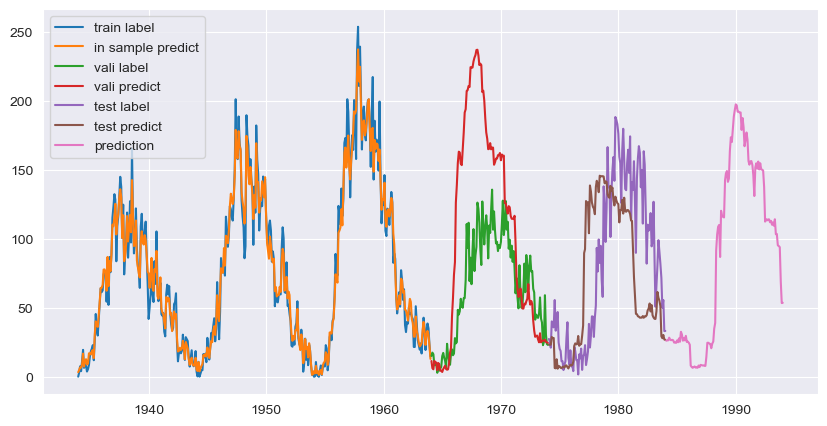

121


<Figure size 640x480 with 0 Axes>

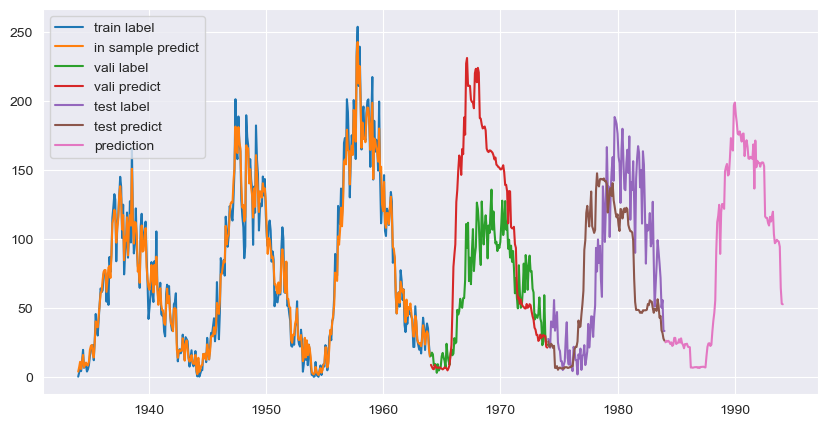

122


<Figure size 640x480 with 0 Axes>

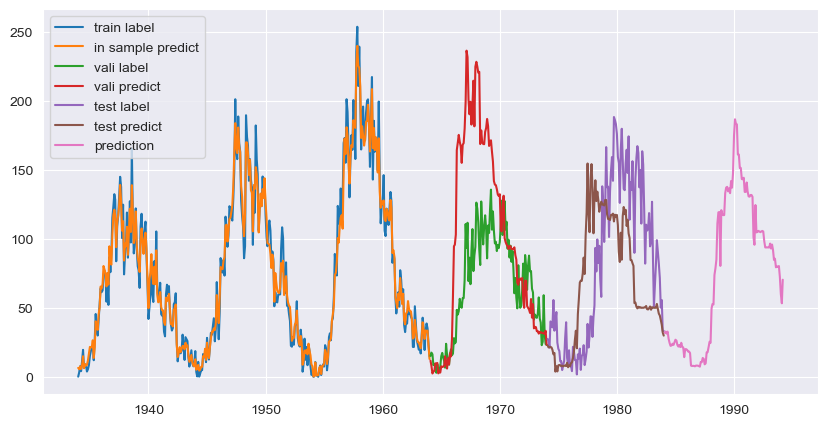

123


<Figure size 640x480 with 0 Axes>

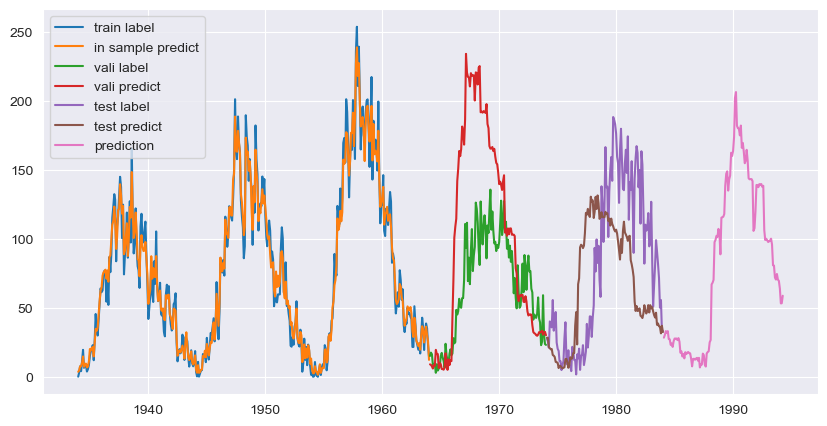

124


<Figure size 640x480 with 0 Axes>

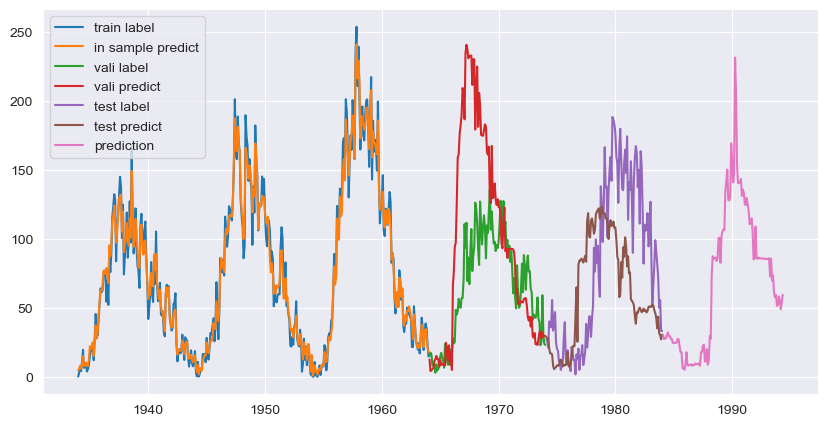

125


<Figure size 640x480 with 0 Axes>

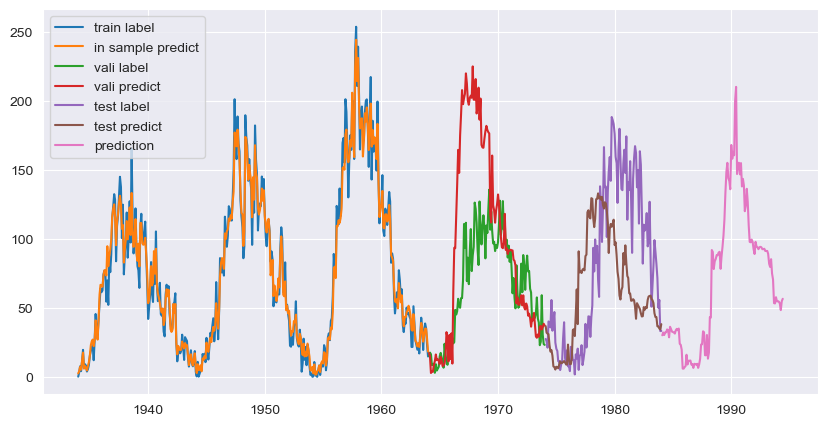

126


<Figure size 640x480 with 0 Axes>

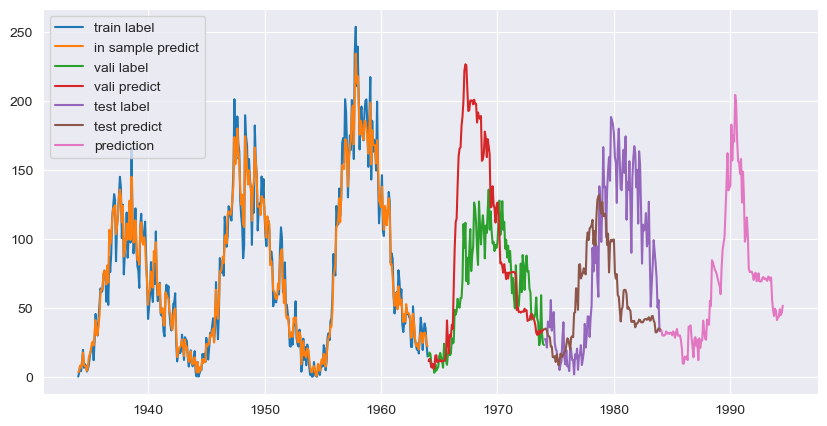

127


<Figure size 640x480 with 0 Axes>

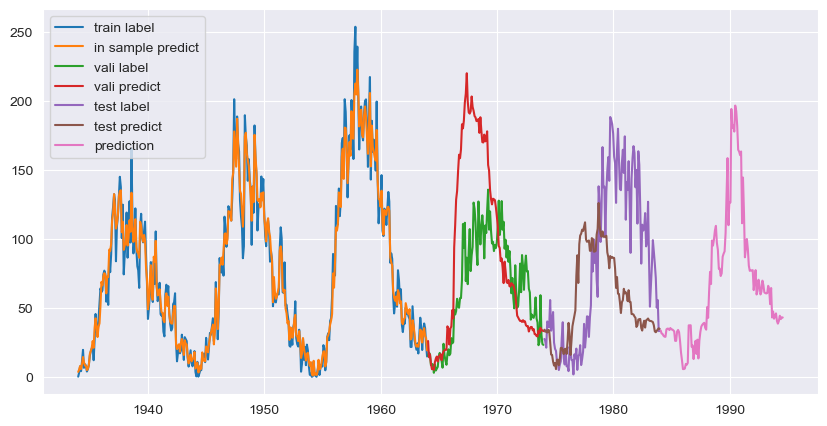

128


<Figure size 640x480 with 0 Axes>

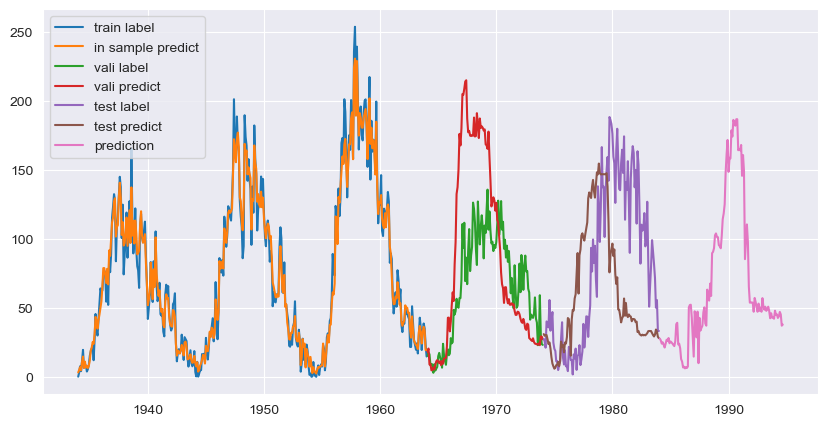

129


<Figure size 640x480 with 0 Axes>

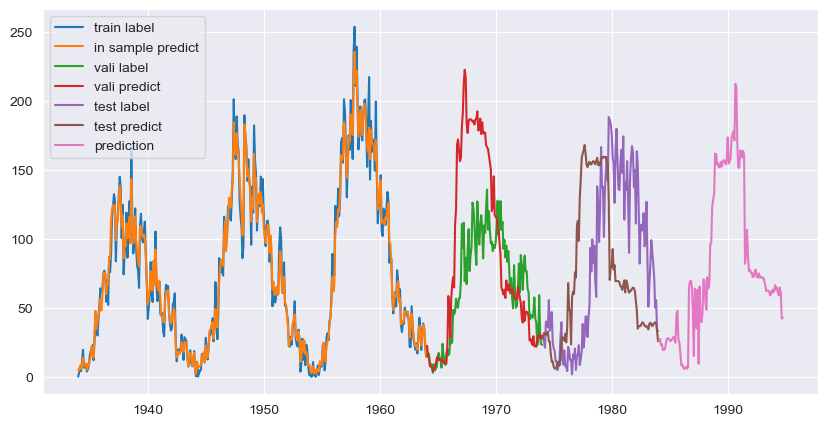

130


<Figure size 640x480 with 0 Axes>

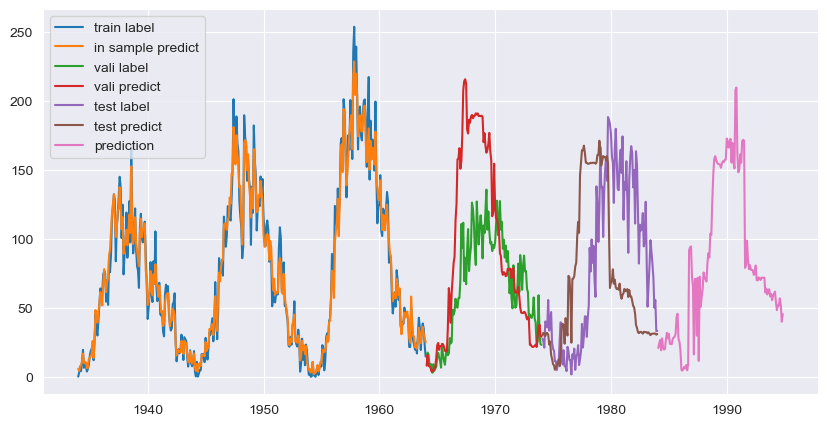

131


<Figure size 640x480 with 0 Axes>

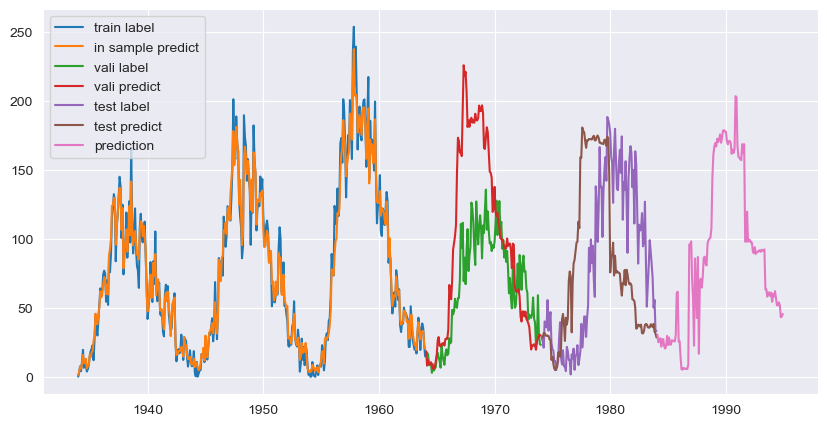

132


<Figure size 640x480 with 0 Axes>

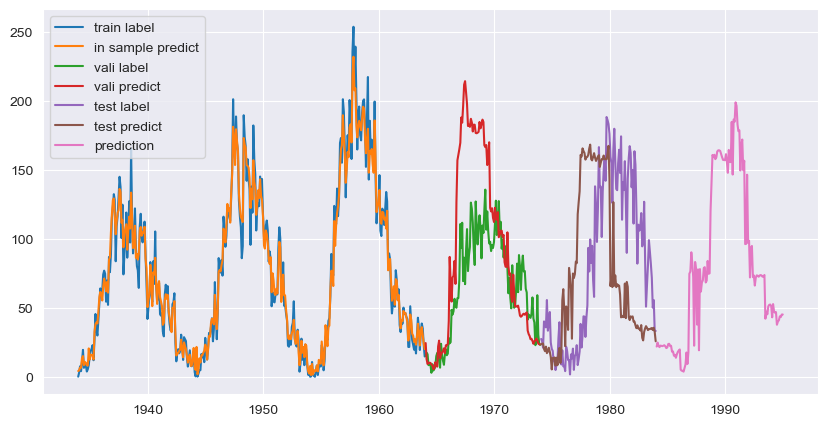

In [19]:
for m, single_result in results.groupby('m'):
    single_result['target_dates'] = pd.to_datetime(single_result['target_dates'])
    print(m)
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(single_result[single_result.type == 'train'].target_dates, single_result[single_result.type == 'train'].target_sunspots,label='train label') # train
    plt.plot(single_result[single_result.type == 'train'].target_dates, single_result[single_result.type == 'train'].predict,label='in sample predict') # test
    plt.plot(single_result[single_result.type == 'vali'].target_dates, single_result[single_result.type == 'vali'].target_sunspots,label='vali label') # train
    plt.plot(single_result[single_result.type == 'vali'].target_dates, single_result[single_result.type == 'vali'].predict,label='vali predict') # test
    plt.plot(single_result[single_result.type == 'test'].target_dates, single_result[single_result.type == 'test'].target_sunspots,label='test label') # train
    plt.plot(single_result[single_result.type == 'test'].target_dates, single_result[single_result.type == 'test'].predict,label='test predict') # test
    plt.plot(single_result[single_result.type == 'prediction'].target_dates, single_result[single_result.type == 'prediction'].predict,label='prediction') # test
    # ax.plot(series.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
    #         color='orange',label='in sample predict') # in-sample
    # ax.plot(fc_series, label='forecast', color='red') # forecast
    # ax.fill_between(series.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
    plt.legend(loc='upper left')
    plt.show()